# Localisation en Intérieur avec Cartes RSSI

Ce notebook traite un problème de localisation en intérieur basé sur des cartes RSSI, avec la distance euclidienne comme métrique pour évaluer l'erreur de localisation. Cette approche permet d'interpréter directement l'erreur en termes de distance réelle.

## Étapes :
1. Chargement et visualisation des cartes RSSI.
2. Compléter les données manquantes par interpolation.
3. Préparation des données pour le modèle.
4. Entraînement d'un modèle de localisation.
5. Évaluation de la performance en utilisant la distance euclidienne.
6. Visualisation des erreurs de localisation.

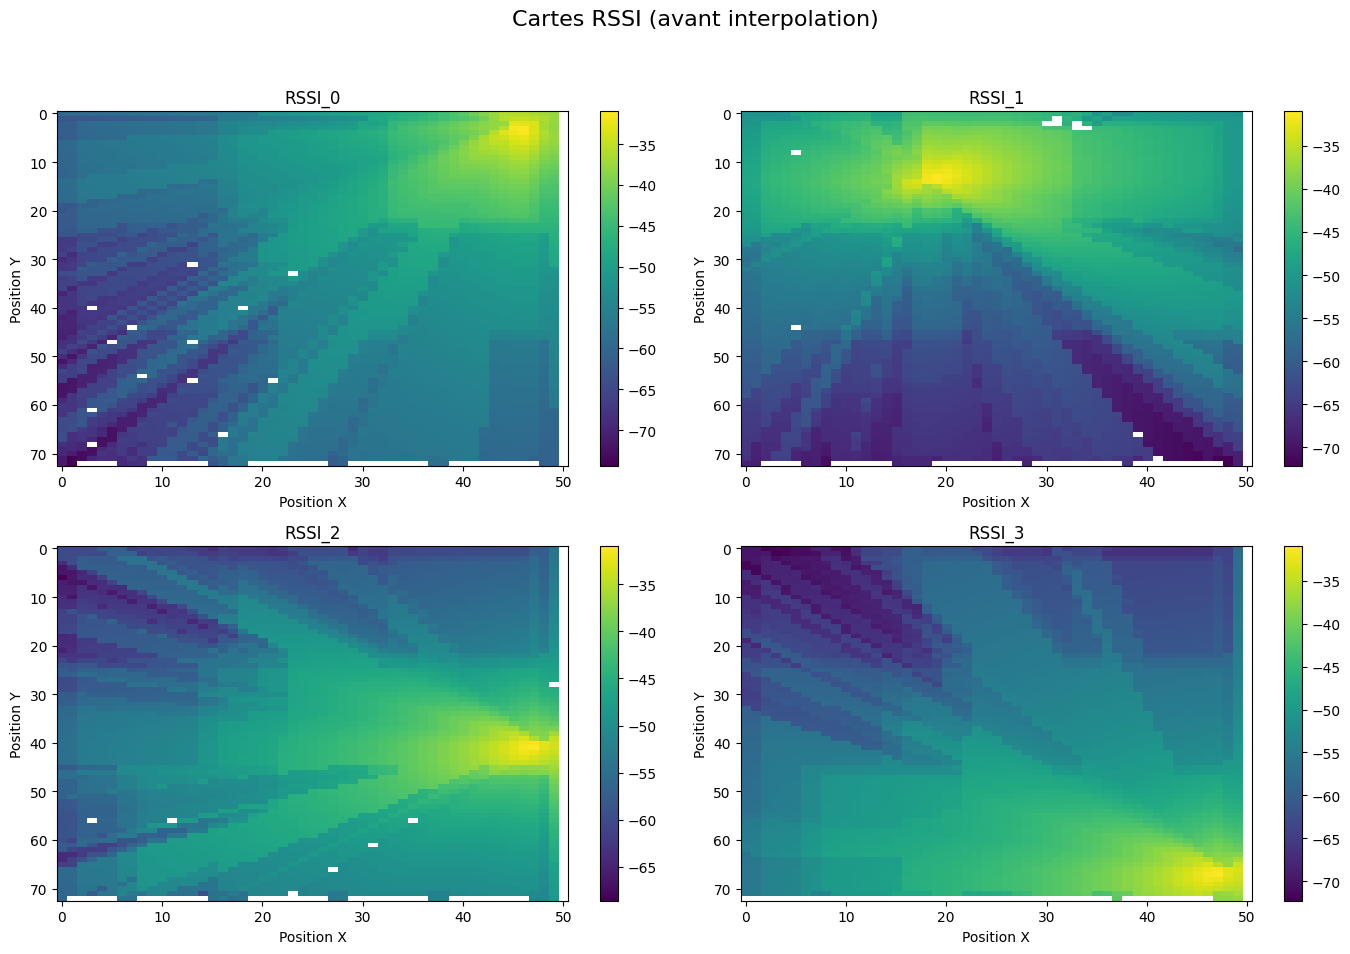

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Chargement des données RSSI
rssi_files = {
    "RSSI_0": "RSSI_0.csv",
    "RSSI_1": "RSSI_1.csv",
    "RSSI_2": "RSSI_2.csv",
    "RSSI_3": "RSSI_3.csv"
}


# Lecture des fichiers dans un dictionnaire de DataFrames
rssi_data = {name: pd.read_csv(file) for name, file in rssi_files.items()}

# Visualisation des cartes RSSI
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Cartes RSSI (avant interpolation)", fontsize=16)

for i, (name, df) in enumerate(rssi_data.items()):
    data_array = df.to_numpy()
    ax = axs[i // 2, i % 2]
    cax = ax.imshow(data_array, cmap="viridis", aspect="auto")
    ax.set_title(name)
    fig.colorbar(cax, ax=ax, orientation="vertical")
    ax.set_xlabel("Position X")
    ax.set_ylabel("Position Y")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


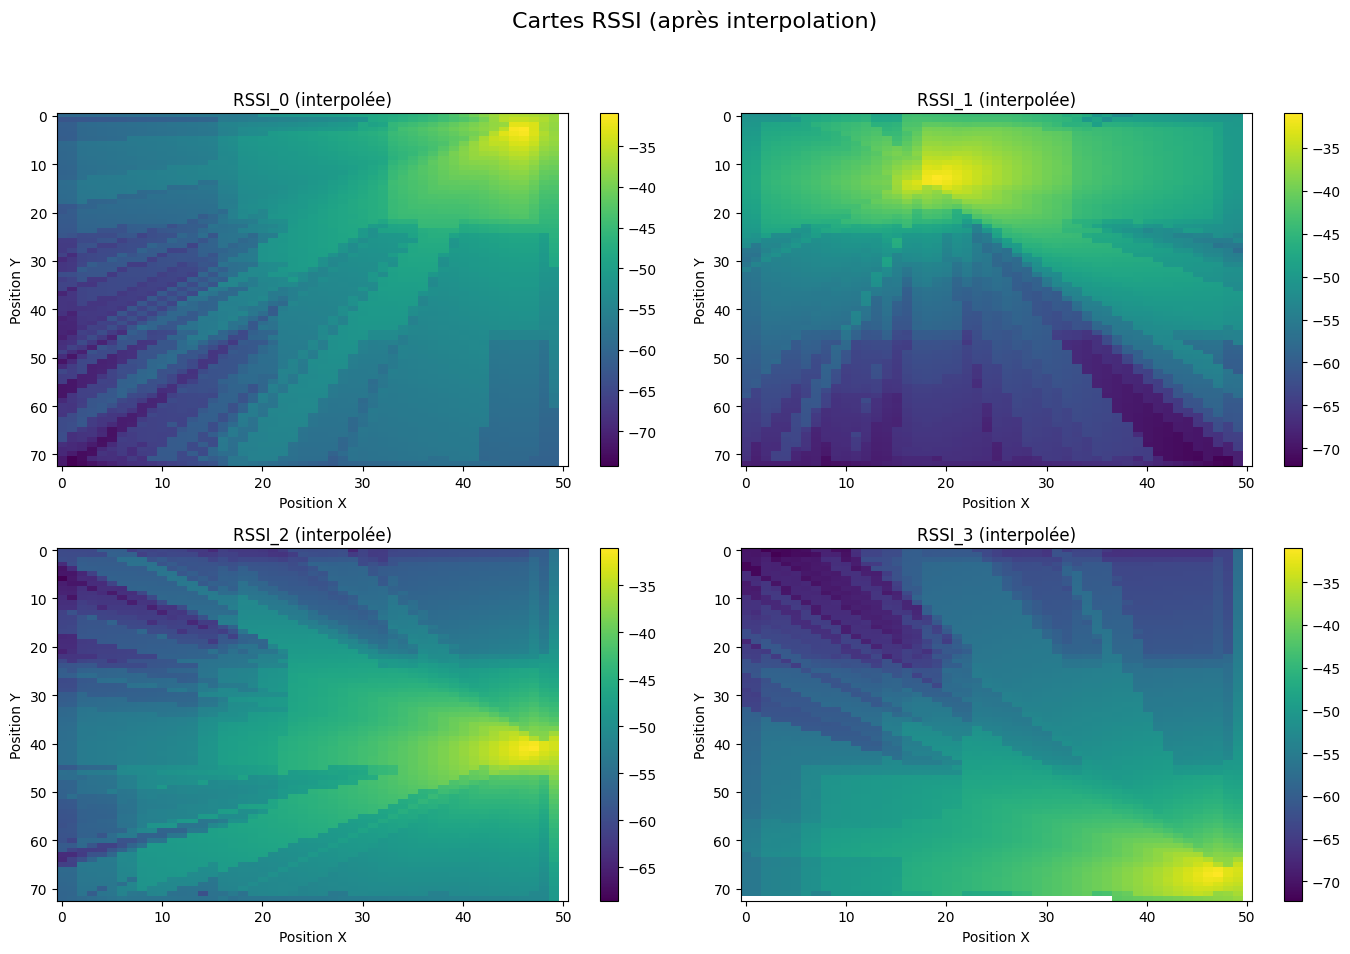

In [2]:

from scipy.interpolate import griddata

# Fonction d'interpolation pour combler les valeurs manquantes
def interpolate_missing_values(df):
    x, y = np.meshgrid(np.arange(df.shape[1]), np.arange(df.shape[0]))
    points = np.array((x[~df.isna()], y[~df.isna()])).T
    values = df.values[~df.isna()]
    xi = np.array((x[df.isna()], y[df.isna()])).T
    df.values[df.isna()] = griddata(points, values, xi, method='linear')
    return df

# Appliquer l'interpolation à chaque carte
interpolated_rssi_data = {name: interpolate_missing_values(df.copy()) for name, df in rssi_data.items()}

# Visualisation des cartes après interpolation
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Cartes RSSI (après interpolation)", fontsize=16)

for i, (name, df) in enumerate(interpolated_rssi_data.items()):
    data_array = df.to_numpy()
    ax = axs[i // 2, i % 2]
    cax = ax.imshow(data_array, cmap="viridis", aspect="auto")
    ax.set_title(f"{name} (interpolée)")
    fig.colorbar(cax, ax=ax, orientation="vertical")
    ax.set_xlabel("Position X")
    ax.set_ylabel("Position Y")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [3]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Préparation des données pour l'entraînement
X = []
y = []

# Extraire les valeurs RSSI (X) et les positions (y)
rows, cols = next(iter(interpolated_rssi_data.values())).shape
for row in range(rows):
    for col in range(cols):
        rssi_values = [interpolated_rssi_data[name].iloc[row, col] for name in interpolated_rssi_data]
        X.append(rssi_values)
        y.append((row, col))

X = np.array(X)
y = np.array(y)

# ** Imputation des valeurs manquantes dans X **
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Séparation des ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2978, 4), (745, 4), (2978, 2), (745, 2))

In [4]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import euclidean

# Entraînement du modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Calcul de l'erreur de localisation en utilisant la distance euclidienne
euclidean_errors = [euclidean(y_pred[i], y_test[i]) for i in range(len(y_test))]
mean_euclidean_error = np.mean(euclidean_errors)
print(f"Erreur moyenne de localisation (Distance Euclidienne) : {mean_euclidean_error:.2f}")

# Mean Squared Error pour comparaison
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (pour information) : {mse:.2f}")


Erreur moyenne de localisation (Distance Euclidienne) : 7.78
Mean Squared Error (pour information) : 44.55


2024-11-09 13:13:29.759200: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 13:13:29.765979: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 13:13:29.788749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731154409.832617  399242 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731154409.845912  399242 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to 

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
24/24 ━━━━━━━━━━━━━━

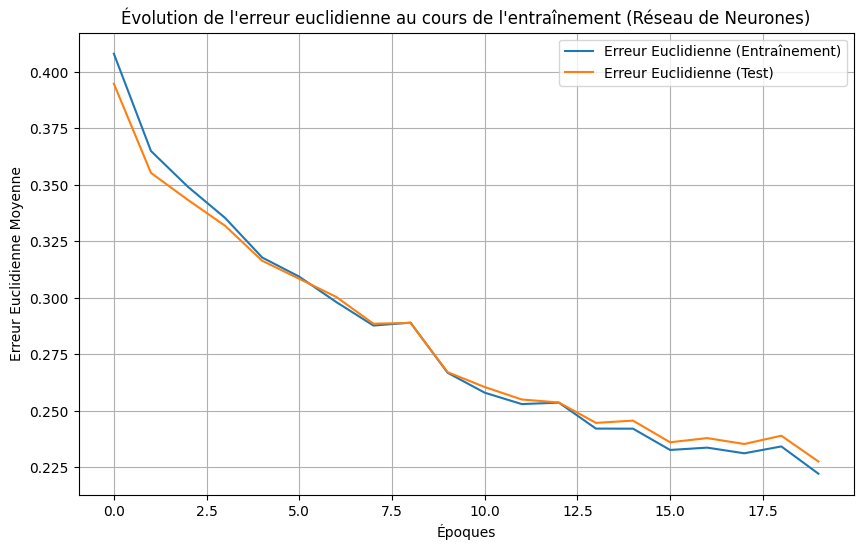

In [5]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

# Préparation des données
# Extraction des valeurs RSSI et des positions
X = []
y = []
rows, cols = next(iter(interpolated_rssi_data.values())).shape
for row in range(rows):
    for col in range(cols):
        rssi_values = [interpolated_rssi_data[name].iloc[row, col] for name in interpolated_rssi_data]
        X.append(rssi_values)
        y.append((row, col))

X = np.array(X)
y = np.array(y)

# Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Normalisation des données
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# Séparation des ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle de réseau de neurones
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(2)  # Deux sorties pour les coordonnées (x, y)
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entraînement du modèle et suivi des erreurs euclidiennes
train_euclidean_errors = []
test_euclidean_errors = []

n_epochs = 20
for epoch in range(n_epochs):
    # Entraîner le modèle pour une époque
    model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
    
    # Calculer l'erreur euclidienne moyenne sur l'ensemble d'entraînement
    y_train_pred = model.predict(X_train)
    train_euclidean_error = np.mean([euclidean(y_train[i], y_train_pred[i]) for i in range(len(y_train))])
    train_euclidean_errors.append(train_euclidean_error)
    
    # Calculer l'erreur euclidienne moyenne sur l'ensemble de test
    y_test_pred = model.predict(X_test)
    test_euclidean_error = np.mean([euclidean(y_test[i], y_test_pred[i]) for i in range(len(y_test))])
    test_euclidean_errors.append(test_euclidean_error)

# Affichage du graphe de la fonction de perte euclidienne
plt.figure(figsize=(10, 6))
plt.plot(train_euclidean_errors, label='Erreur Euclidienne (Entraînement)')
plt.plot(test_euclidean_errors, label='Erreur Euclidienne (Test)')
plt.xlabel("Époques")
plt.ylabel("Erreur Euclidienne Moyenne")
plt.title("Évolution de l'erreur euclidienne au cours de l'entraînement (Réseau de Neurones)")
plt.legend()
plt.grid(True)
plt.show()




Epoch 1/20


/usr/local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1: R2 train = 0.3792, R2 test = 0.3761
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 483.6823 - val_loss: 172.5587
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 2: R2 train = 0.5518, R2 test = 0.5786
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 144.7398 - val_loss: 106.5863
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 3: R2 train = 0.6118, R2 test = 0.6340
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 105.0233 - val_loss: 93.0338
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: R2 train = 0.6319, R2 test = 0.6497
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 94.1091 - val_loss: 88.9169
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 5: R2 train = 0.6222, R2 test = 0.6502
94/94 ━━━━━━

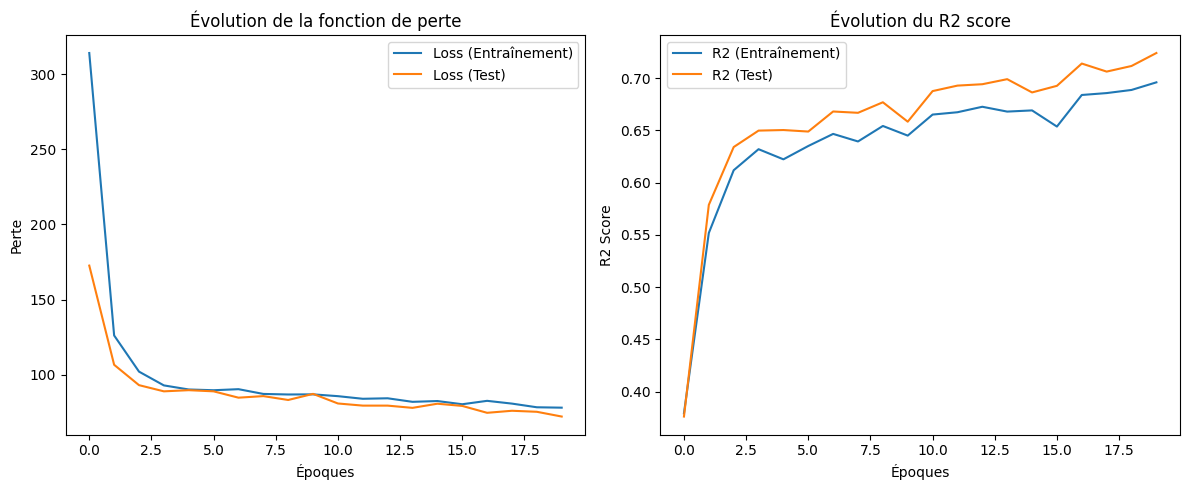

In [6]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf

# Préparation des données
# (on suppose que les données interpolées sont dans interpolated_rssi_data)

# Extraire les valeurs RSSI et les positions
X = []
y = []

rows, cols = next(iter(interpolated_rssi_data.values())).shape
for row in range(rows):
    for col in range(cols):
        rssi_values = [interpolated_rssi_data[name].iloc[row, col] for name in interpolated_rssi_data]
        X.append(rssi_values)
        y.append((row, col))

X = np.array(X)
y = np.array(y)

# Imputer les valeurs manquantes
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Séparer en ensemble d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle de réseau de neurones
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(2)  # Deux sorties pour les coordonnées (x, y)
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Fonction de callback pour calculer le R2 score après chaque époque
class R2Callback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__()
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.train_r2 = []
        self.test_r2 = []

    def on_epoch_end(self, epoch, logs=None):
        # Calculer le R2 score pour les ensembles d'entraînement et de test
        train_pred = self.model.predict(self.X_train)
        test_pred = self.model.predict(self.X_test)
        train_r2 = r2_score(self.y_train, train_pred)
        test_r2 = r2_score(self.y_test, test_pred)
        self.train_r2.append(train_r2)
        self.test_r2.append(test_r2)
        print(f"Epoch {epoch+1}: R2 train = {train_r2:.4f}, R2 test = {test_r2:.4f}")

# Entraînement du modèle avec le callback pour le R2
r2_callback = R2Callback(X_train, X_test, y_train, y_test)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[r2_callback])

# Tracer les courbes de la fonction de perte et du R2 score
# Historique de la perte
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (Entraînement)')
plt.plot(history.history['val_loss'], label='Loss (Test)')
plt.title("Évolution de la fonction de perte")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

# Historique du R2
plt.subplot(1, 2, 2)
plt.plot(r2_callback.train_r2, label='R2 (Entraînement)')
plt.plot(r2_callback.test_r2, label='R2 (Test)')
plt.title("Évolution du R2 score")
plt.xlabel("Époques")
plt.ylabel("R2 Score")
plt.legend()

plt.tight_layout()
plt.show()

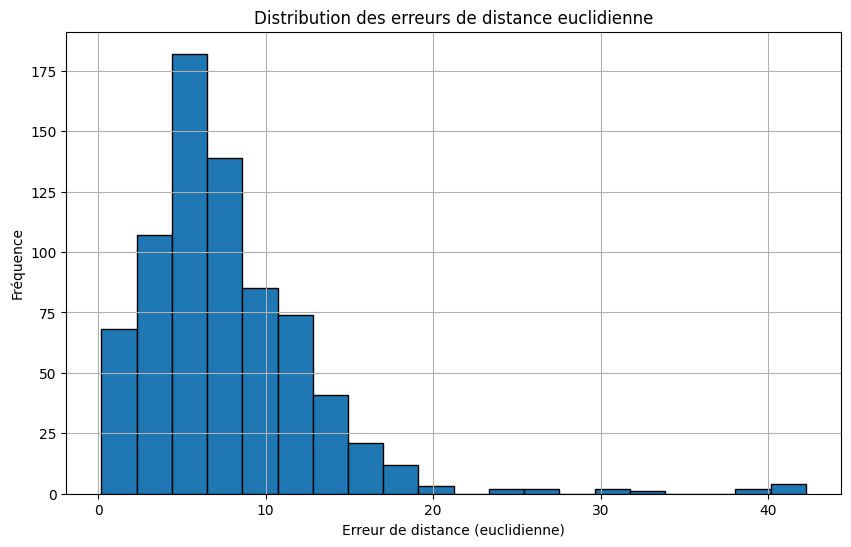

In [7]:

# Histogramme des erreurs de distance euclidienne
plt.figure(figsize=(10, 6))
plt.hist(euclidean_errors, bins=20, edgecolor='k')
plt.title("Distribution des erreurs de distance euclidienne")
plt.xlabel("Erreur de distance (euclidienne)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()
